## Modeling (Baseline Model and Model Training)

After having done the initial EDA in the previous notebook, we move now to the part of modeling. As already stated in the EDA notebook, due to the huge amount of data and the various hdd models, we start by working on a model solely for the Seagate ST4000DM000.

While our code is aimed to allow reproducibility for any other hard drive model, this model is the focus of this notebook.

Before we start training machine learning algorithm, we construct our baseline model, which we derive based on the important features derived in the last notebook.

After this we try some standard classification and regression models. First solely on the features deemed important for the baseline model and then extent/create new features.

We also use MLFlow to track our "experiments" and use this function to track our baseline model, as well as the machine learning models which are trained after this.

As usual we start by importing relevant libraries.

In [59]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import mlflow

# define the sys.path for importing the load_preprocess_data function
sys.path.append("..")

# import our function for pre-processing the raw data for the selected hard drive
from src.data.preprocessing import load_preprocess_data
from src.data.preprocessing import train_test_splitter

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

# set the plotting styel for the notebook
plt.style.use('seaborn')
sns.set(rc={'axes.facecolor':'#fae5d2', 'figure.facecolor':'white'})

# define the random seed for modelling and train-test split
RSEED = 42

In [2]:
# # Setup MLFlow
# EXPERIMENT_NAME = "guardians_of_the_memory_daniela"
# TRACKING_URI = open("../.mlflow_uri").read().strip()

In [3]:
# use the load_preprocess_data function to pre-process the raw data and load it into a pandas data frame
repo_path = os.getcwd()+"/../"
df = load_preprocess_data(path=repo_path)
df.shape

(462966, 42)

In [4]:
def classification_target(cols):
    classification = cols[0]
    if classification <= 30:
        return 1
    if classification > 30:
        return 0

df['fail_30'] = df[['countdown']].apply(classification_target, axis=1)

## Baseline Model

Based on the information derived out of the EDA, we focus on the smart features 5, 183, 184 and 187 for our baseline model and leave aside other features. We especially try not to focus on time/age related features such as feature 9, 240, 241, 242, etc. in order to try to spot other "technical indications" of a failure.

We calculate the median of those features a certain time span before the drives fail. This median serves than as the threshold four our baseline model. However, due to slightly different behavior of the features before failing, we predict that if two (out of the four) features are above the threshold the drive will fail in the given time window.

Before we construct the baseline model we look again shortly into these 4 features.

In [5]:
# create a helper column containing the features we want to use for plotting
columns = []

for col in df.columns:
    if '5' in col or '183' in col or '184' in col or '187' in col:
        if 'raw' in col:
            columns.append(col)

In [6]:
# call the descriptive statistics and transpose the data frame for readability
df[columns].describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,462966.0,126.252813,1918.915422,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,462966.0,3.838230,29.389742,0.0,0.0,0.0,2.0,720.0
smart_184_raw,462966.0,0.148525,4.021683,0.0,0.0,0.0,0.0,340.0
smart_187_raw,462966.0,5.123342,25.932870,0.0,0.0,0.0,0.0,940.0


We can already see fro the descriptive statistic for these 4 features that the mean might not be the best indicator as the 25%, 50% and 75% are all 0. 

Thus, we next look into the median for these values when only taking the fail_30 into consideration.

In [7]:
# call the descriptive statistics and transpose the data frame for readability split by fail_30
display(df[df['fail_30'] == 0][columns].describe().T)
display(df[df['fail_30'] == 1][columns].describe().T)

,count,mean,std,min,25%,50%,75%,max
smart_5_raw,444121.0,102.880683,1732.393128,0.0,0.0,0.0,0.0,65064.0
smart_183_raw,444121.0,3.591753,28.318550,0.0,0.0,0.0,1.0,720.0
smart_184_raw,444121.0,0.070472,2.207922,0.0,0.0,0.0,0.0,180.0
smart_187_raw,444121.0,4.005969,20.882659,0.0,0.0,0.0,0.0,773.0


,count,mean,std,min,25%,50%,75%,max
smart_5_raw,18845.0,677.064898,4406.507789,0.0,0.0,0.0,0.0,65488.0
smart_183_raw,18845.0,9.646962,47.807292,0.0,0.0,1.0,4.0,720.0
smart_184_raw,18845.0,1.988007,16.701659,0.0,0.0,0.0,0.0,340.0
smart_187_raw,18845.0,31.456514,74.309154,0.0,0.0,3.0,28.0,940.0


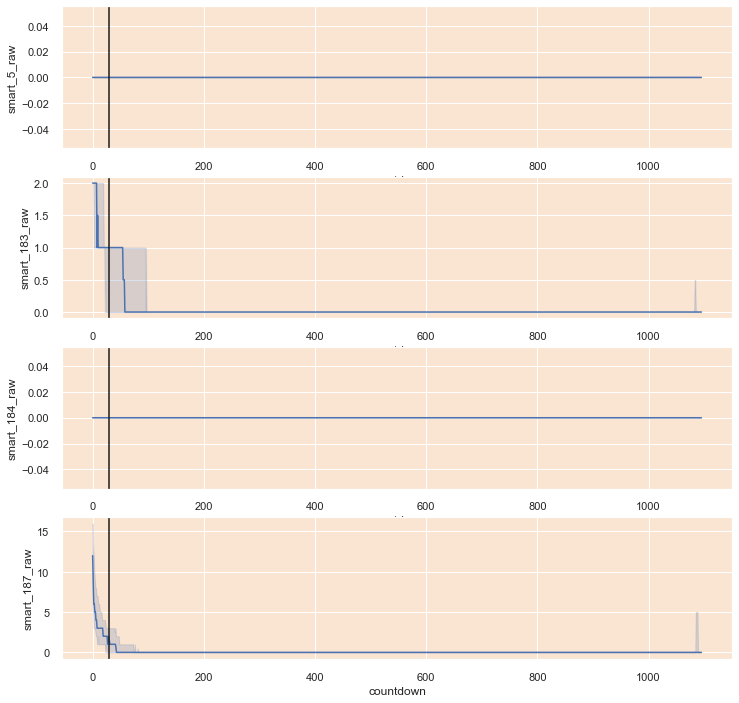

In [8]:
# set the time window (for classification task this is the respective cut off date)
time_window = 30

# plot the important features identified and indicate the time_window
plt.figure(figsize=(12,12))
for num, feat in enumerate(columns):
    plt.subplot(4,1,num+1)
    sns.lineplot(x=df.countdown, y=df[feat], color='#327343', linewidth=2, estimator=np.median)
    plt.axvline(x=time_window, c='#595959',linestyle='--', linewidth=2)

In [9]:
smart_features = ['smart_5_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw']
feature_names = ['Reallocated Sectors Count', 'Runtime Bad Block', 'End-to-End error', 'Reported Uncorrectable Errors']
serial_number_list = []

df[smart_features] = np.log(df[smart_features]+1)
df = df.query('countdown <= 500')

In [10]:
# for feature in smart_features:
#     g = sns.lineplot(x=df.countdown, y=df[feature], label=feature, ci=0, color='r')
#     g.set_title('Important Smart Features - Development over Time', fontsize=18)
#     g.set_ylabel('smart features', fontsize=13)
#     g.set_xlabel('Days until drive failure', fontsize=13)
#     g.set_xlim(-5)
#     g.set_ylim(-0.1)
#     g.legend()

#     plt.savefig('../images/importantfeatures.png', bbox_inches = "tight")

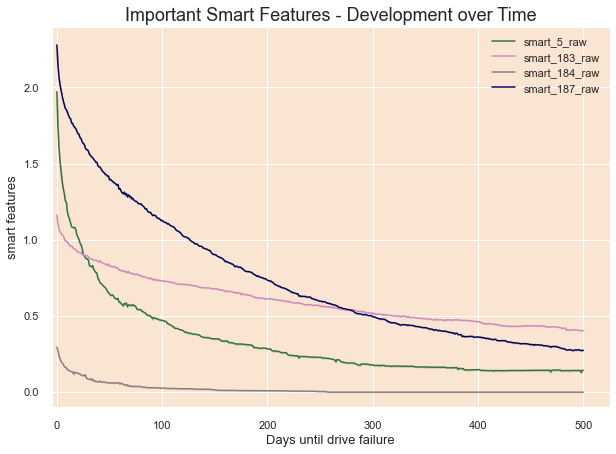

In [18]:
plt.figure(figsize=(10, 7))

g = sns.lineplot(x=df.countdown, y=df['smart_5_raw'], label='smart_5_raw', ci=0, color='#327343')
g = sns.lineplot(x=df.countdown, y=df['smart_183_raw'], label='smart_183_raw', ci=0, color='#CD8CBC')
g = sns.lineplot(x=df.countdown, y=df['smart_184_raw'], label='smart_184_raw', ci=0, color='#8a7f80')
g = sns.lineplot(x=df.countdown, y=df['smart_187_raw'], label='smart_187_raw', ci=0, color='#02075d')
g.set_title('Important Smart Features - Development over Time', fontsize=18)
g.set_ylabel('smart features', fontsize=13)
g.set_xlabel('Days until drive failure', fontsize=13)
g.set_xlim(-5)
g.set_ylim(-0.1)
g.legend()

plt.savefig('../images/importantfeatures_1.png', bbox_inches = "tight")

Let us look at some single examples

In [12]:
# calculate the threshold based on the full data set
threshold = df[df['fail_30'] == 1][smart_features].median()
threshold = np.log(threshold+1)
threshold

smart_5_raw      0.000000
smart_183_raw    0.526589
smart_184_raw    0.000000
smart_187_raw    0.869742
dtype: float64

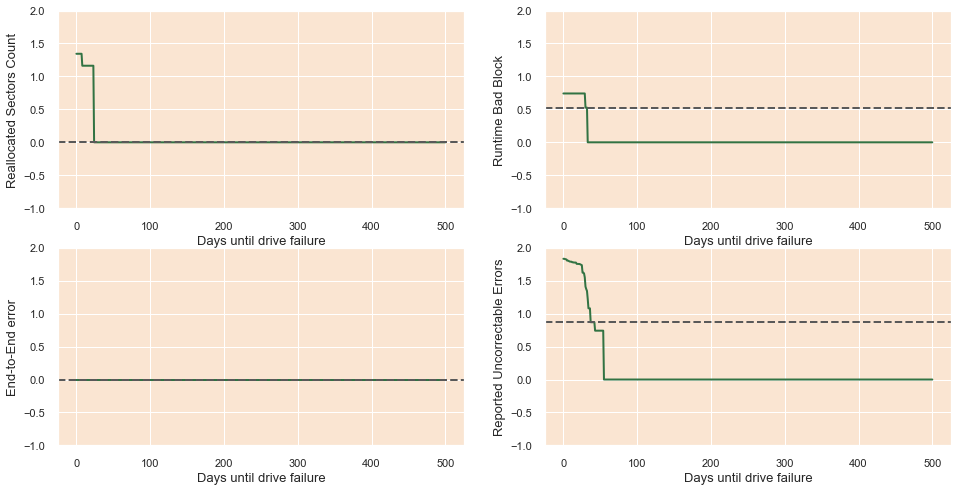

In [13]:
serial = df.sample(1)['serial_number'].to_list()[0]
serial_number_list.append(serial)
data = df[df['serial_number'] == 'S300ZAXR']

# scaler = MinMaxScaler()
# data[smart_features] = scaler.fit_transform(data[smart_features])

data[smart_features] = np.log(data[smart_features]+1)

counter = 0

fig, ax = plt.subplots(2,2, figsize=(16,8))

for index, feature in enumerate(smart_features):
    sns.lineplot(x=data.countdown, y=data[feature], color='#327343', linewidth=2, ax=ax[counter,(index % 2)])
    #ax[counter,(index % 2)].set_title(feature_names[index], fontsize=18)
    ax[counter,(index % 2)].set_ylabel(feature_names[index], fontsize=13)
    ax[counter,(index % 2)].set_xlabel('Days until drive failure', fontsize=13)
    ax[counter,(index % 2)].axhline(y=threshold[feature], c='#595959',linestyle='--', linewidth=2)
    ax[counter,(index % 2)].set_xlim(-25)
    ax[counter,(index % 2)].set_ylim(-1, 2)

    if index == 1 or index == 3:
        counter += 1

plt.savefig('../images/baselinefeatures.png', bbox_inches = "tight")


# for feature in smart_features:
#     g = sns.lineplot(x=data.countdown, y=data[feature], label=feature)
#     #g.set_title('Important Smart Features - Development over Time', fontsize=18)
#     g.axhline(y=threshold[feature])
#     g.set_ylabel('smart features', fontsize=13)
#     g.set_xlabel('Days until drive failure', fontsize=13)
#     g.set_xlim(-5)
#     g.set_ylim(-0.1)
#     g.legend()

#     plt.savefig('../images/baselinefeatures_together.png', bbox_inches = "tight")

Smart_183_raw and smart_187_raw seem to be very good indicators. smart_5_raw and smart_184_raw are also good indicators (check mean plots), but only for a small fraction of HDDs.

Towards large values of days_to_fail, we observe some fluctuations. The come from the fact, that we have only very limited statistics available. The number of HDDs in the dataset decreases as a function of days_to_fail, since a rather constant fail rate "takes them out day by day". This can be seen in the following lineplot.

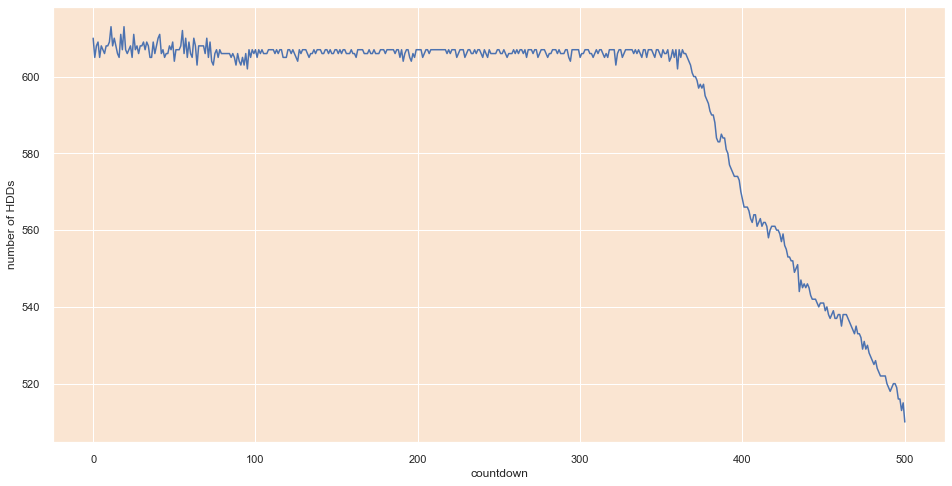

In [14]:
# plot the number of hdds drives over the countdown target
plt.figure(figsize=(16,8))

sns.lineplot(data=df.groupby("countdown").count().date)

plt.ylabel("number of HDDs");

### Train-Test Split

For the first baseline model we take a generic train test split, where we only use stratify to assure that we are having the same proportion of failure and not failure data within both data sets.

In [19]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RSEED, stratify=y)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

# set the data_split approach for MLFlow communication
data_split = 'stratify on y'

X_train: (222513, 4)
X_test: (74171, 4)
y_train: (222513,)
y_test: (74171,)


In [20]:
# calculate the threshold based on the train data set
df_train = pd.concat([X_train, pd.Series(y_train, name='fail_30')], axis=1)
threshold = df_train[df_train['fail_30'] == 1][columns].median()
threshold

smart_5_raw      0.000000
smart_183_raw    0.693147
smart_184_raw    0.000000
smart_187_raw    1.386294
dtype: float64

In [21]:
# # set up MLFlow
# mlflow.set_tracking_uri(TRACKING_URI)
# mlflow.set_experiment(EXPERIMENT_NAME)

# name = "baseline_model"

# # activate MLFlow
# mlflow.start_run(run_name=name)
# run = mlflow.active_run()

# # print run_id
# print("Active run_id: {}".format(run.info.run_id))

In [22]:
# set threshold for the baseline model
num_above_threshold = 2

# use the thresholds to calculate the predicted values for the train and test set
y_train_pred = (X_train > threshold).sum(axis=1) > (num_above_threshold-1)
y_test_pred = (X_test > threshold).sum(axis=1) > (num_above_threshold-1)

#### Baseline Model Performance

With this we have now created our first baseline model and in the next part we use the specified metric to look into the model performance.

While we decided on the F2 score (with a higher focus on precision), we still check the different metrics like accuracy, recall and precision, as well as the confusion matrix do understand model performance

#### Splitting the data

As we are working with sequential data another approach for the train test split is to divide the data alongside the serial_numbers. This way we can assure that we do not split the serial_numbers into the train and test split and does interrupt the sequential data.  

##### Train Set Evaluation

In [65]:
# create a helper column containing the features we want to use for plotting
columns = ['serial_number']

for col in df.columns:
    if '5' in col or '183' in col or '184' in col or '187' in col:
        if 'raw' in col:
            columns.append(col)

In [66]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (207998, 5)
X_test: (88686, 5)
y_train: (207998,)
y_test: (88686,)


#### Setting up the MLFlow connection

Next we again set up the MLFlow for the second baseline model. We use the same hyperparameter, but choose a different train test split, so we also track this with a separate parameter.

In [31]:
# # setting the MLFlow connection and experiment
# mlflow.set_tracking_uri(TRACKING_URI)
# mlflow.set_experiment(EXPERIMENT_NAME)

# # define the run name 
# name = "baseline_model"

# # start MLFlow 
# mlflow.start_run(run_name=name)
# run = mlflow.active_run()

# # print the run_id
# print("Active run_id: {}".format(run.info.run_id))

#### Calculating the baseline model

In [67]:
# set threshold for the baseline model
num_above_threshold = 2

# use the thresholds to calculate the predicted values for the train and test set
y_train_pred = (X_train > threshold).sum(axis=1) > (num_above_threshold-1)
y_test_pred = (X_test > threshold).sum(axis=1) > (num_above_threshold-1)

#### Baseline Model Performance

##### Train Set Evaluation

Train - F2 score : 0.33
Train - ROC AUC  : 0.64
Train - Recall   : 0.42
Train - Accuracy : 0.84


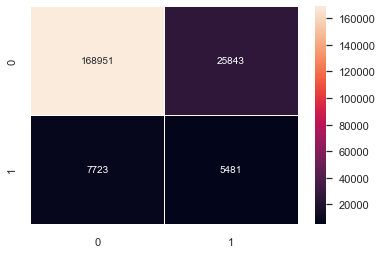

In [34]:
# calculate the training values and save them in the respective variables
fbeta_train = fbeta_score(y_train, y_train_pred, beta=2).round(2)
auc_train = roc_auc_score(y_train, y_train_pred).round(2)
recall_train = recall_score(y_train, y_train_pred).round(2)
accuracy_train = accuracy_score(y_train, y_train_pred).round(2)

# print the training scores
print("Train - F2 score :", fbeta_train)
print("Train - ROC AUC  :", auc_train)
print("Train - Recall   :", recall_train)
print("Train - Accuracy :", accuracy_train)

# create the confusion matrix
confusion_matrix(y_train, y_train_pred)

# plot the confusion matrix using seaborn
cm = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

##### Test Set Evaluation

Test - F2 score : 0.29
Test - ROC AUC  : 0.62
Test - Recall   : 0.41
Test - Accuracy   : 0.79


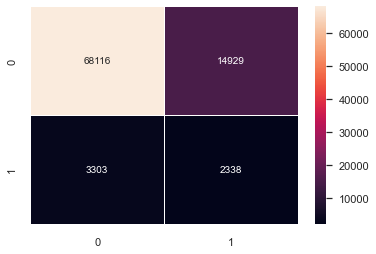

In [35]:
# calculate the test values and save them in the respective variables
fbeta_test = fbeta_score(y_test, y_test_pred, beta=2).round(2)
auc_test = roc_auc_score(y_test, y_test_pred).round(2)
recall_test = recall_score(y_test, y_test_pred).round(2)
accuracy_test = accuracy_score(y_test, y_test_pred).round(2)

# print the test scores
print("Test - F2 score :", fbeta_test)
print("Test - ROC AUC  :", auc_test)
print("Test - Recall   :", recall_test)
print("Test - Accuracy   :", accuracy_test)

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix using seaborn
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

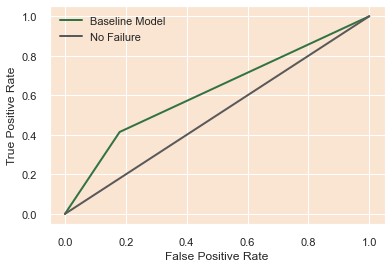

In [37]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_pred)
base = np.linspace(0,1,100)
sns.lineplot(fpr, tpr, color='#327343', linewidth=2,)
sns.lineplot(base, base, color='#595959', linewidth=2,)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(["Baseline Model", "No Failure"]);

#### Logging the baseline model performance on MLFlow

In [ ]:
# # Logging on MLFlow
# params = {
#       "thresholds": threshold,
#       "time_to_fail": time_window,
#       "features_above_threshold": num_above_threshold,
#       "data_split": data_split
#   }

In [ ]:
# #logging params to mlflow
# mlflow.log_params(params)

# #setting tags
# mlflow.set_tag("running_from_jupyter", "True")
# mlflow.set_tag("model", "Baseline")

# #logging metrics
# mlflow.log_metric("train_" + "f-2 score", fbeta_train)
# mlflow.log_metric("test_" + "f-2 score", fbeta_test)

# # logging the model to mlflow will not work without a AWS Connection setup.. too complex for now
# # but possible if running mlflow locally
# # mlflow.log_artifact("../models")
# # mlflow.sklearn.log_model(reg, "model")

# mlflow.end_run()

The two baseline models were used to identify if the split based on stratify is enough or if we can achieve higher results based on avoiding splits of the serial numbers. As both approaches deem the same result, we continue splitting the data solely on the 'stratify=y' approach.

## DecisionTreeClassifier

After designing our baseline model, we train a model using similar features (5, 183, 184, 187) and feed a decision tree and a random forest with this data.

Based on this outcome we look into other relevant columns, potential feature engineering, etc.

While we already have a train test split in place that would fullfil the requirements, we create a new train test split using the normal stratify parameter.

In [69]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

X_train.drop('serial_number', axis=1, inplace=True)
X_test.drop('serial_number', axis=1, inplace=True)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (207998, 4)
X_test: (88686, 4)
y_train: (207998,)
y_test: (88686,)


In [62]:
# instantiating the tree classifier and training it on the train data
tree = DecisionTreeClassifier(min_samples_leaf=20, random_state=42)
tree.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=20, random_state=42)

Scores:
-------------------------
ROC-AUC : 0.5632
Accuracy : 0.9116
Recall   : 0.1642
Precision: 0.2284
F1 Score: 0.1910
F2 Score : 0.1739


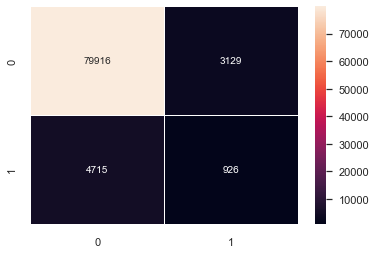

In [44]:
# create the predictions using the previously trained model
y_test_pred = tree.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

The simple decision tree with only the four features 5, 183,184, 187 without any additional hyperparameter tuning performs not as good as our baseline model. 

Still it might give valuable information to look into the feature importance, to understand which features had a higher relevance for splitting the nodes.

### Feature Importance

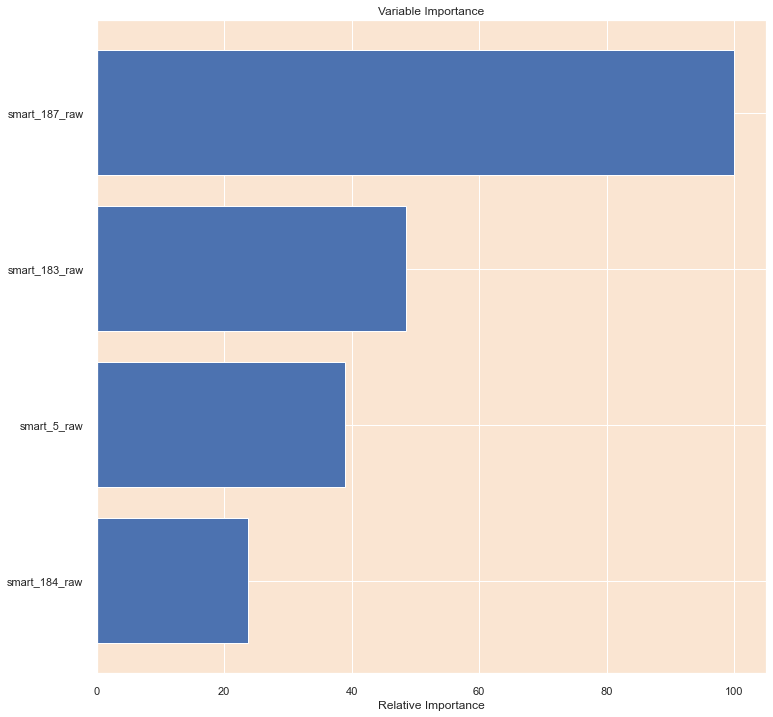

In [45]:
# plot feature importance
feature_importance = tree.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The simple tree puts the highest importance on the 187 feature. Let us look into the random forest to understand if the other classifier also puts the same importance on these four features.

## RandomForestClassifier

Next we try a generic Random Forest Classifier and see how well this machine learning algorithm handles the data and see how well it performs in comparison to the baseline model and the single decision tree.

As we already have a train test split created for the decision tree, we will use the same train test split and still limit ourselves to the four features selected (5, 183, 184, 187).

In [70]:
# check on the training data to make sure that we have the correct features selected
X_train.head()

,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
1,0.0,1.791759,0.0,1.791759
3,0.0,0.000000,0.0,0.000000
4,0.0,1.098612,0.0,0.000000
5,0.0,1.386294,0.0,2.708050
7,0.0,1.098612,0.0,2.564949


Scores:
-------------------------
ROC-AUC : 0.5741
Accuracy : 0.8904
Recall   : 0.2117
Precision: 0.1845
F1 Score: 0.1972
F2 Score : 0.2056


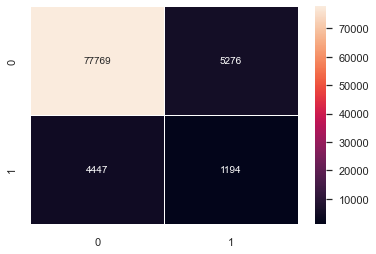

In [49]:
from sklearn.ensemble import RandomForestClassifier

# instantiate and train the model
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)

# predict the target variable using the trained model
y_test_pred = forest.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

Next we look at the feature importance for the Random Forest Classifier.

#### Feature Importance

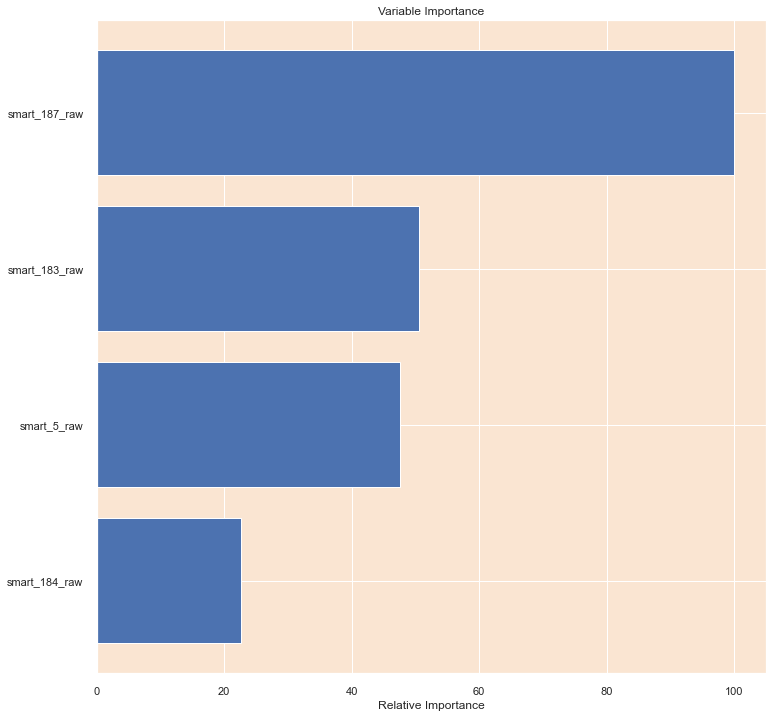

In [50]:
# Plot feature importance
feature_importance = forest.feature_importances_

# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Upgrading our Tree Based Model - XGBoost

In [71]:
# check on the training data to make sure that we have the correct features selected
X_train.head()

,smart_5_raw,smart_183_raw,smart_184_raw,smart_187_raw
1,0.0,1.791759,0.0,1.791759
3,0.0,0.000000,0.0,0.000000
4,0.0,1.098612,0.0,0.000000
5,0.0,1.386294,0.0,2.708050
7,0.0,1.098612,0.0,2.564949


[17:20:07] WARNING: /private/var/folders/4y/dlsvl9zd1blcnj6j3_tsc0j00000gn/T/pip-install-yrved5qh/xgboost_b33a4a38e5e54893acac00c429e943b9/build/temp.macosx-12.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores:
-------------------------
ROC-AUC : 0.5696
Accuracy : 0.9119
Recall   : 0.1775
Precision: 0.2399
F2 Score : 0.1872


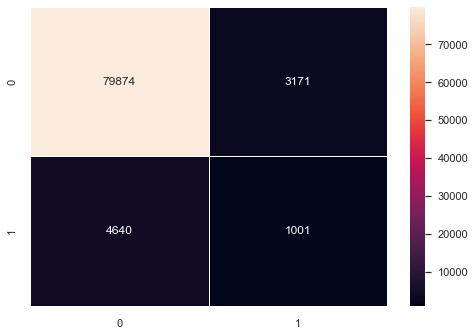

In [73]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

# predict the target variable using the trained model
y_test_pred = clf.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

While both models put the highest emphasize on the smart_187_raw feature. The second and third feature have a different order for the decision tree and random forest. Random Forest puts a higher importance on the smart_5_raw while in comparison treats the smart_183_raw as a more important feature.

### Improving our models

Next, we see if our decision tree classifier or random forest classifier performs better if we add additional features to it. As of know we have not used any time/age related features, but as they might be relevant for the failure, we use some of them within the next approach.

First we select the 9th feature which is indicating the run-time of the hdd as well as the 240th feature.

In [74]:
# create a helper column containing the features we want to use for plotting
columns = ['serial_number']

for col in df.columns:
    if '5' in col or '_9_' in col or '183' in col or '184' in col or '187' in col or '240' in col:
        if 'raw' in col:
            columns.append(col)

In [75]:
# split the data into features and target
X = df[columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

X_train.drop('serial_number', axis=1, inplace=True)
X_test.drop('serial_number', axis=1, inplace=True)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (207998, 6)
X_test: (88686, 6)
y_train: (207998,)
y_test: (88686,)


As expected after the result, the model is placing a high importance on the added two features. Next we try to apply this same data set to the Random Forest Classifier and see what the outcome of this one is.

## RandomForest Upgraded

In [76]:
# instantiate and train the model
forest_check = RandomForestClassifier()
forest_check.fit(X_train, y_train)

# create the predictions using the previously trained model
y_test_pred = forest_check.predict(X_test)

Scores:
-------------------------
ROC-AUC : 0.5901
Accuracy : 0.8969
Recall   : 0.2386
Precision: 0.2173
F1 Score: 0.2274
F2 Score : 0.2340


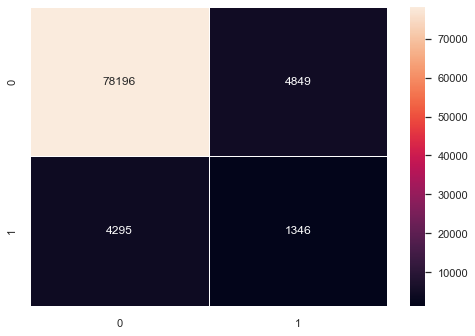

In [77]:
# create the predictions using the previously trained model
y_test_pred = forest_check.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

[17:21:19] WARNING: /private/var/folders/4y/dlsvl9zd1blcnj6j3_tsc0j00000gn/T/pip-install-yrved5qh/xgboost_b33a4a38e5e54893acac00c429e943b9/build/temp.macosx-12.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores:
-------------------------
ROC-AUC : 0.5859
Accuracy : 0.9125
Recall   : 0.2118
Precision: 0.2648
F2 Score : 0.2207


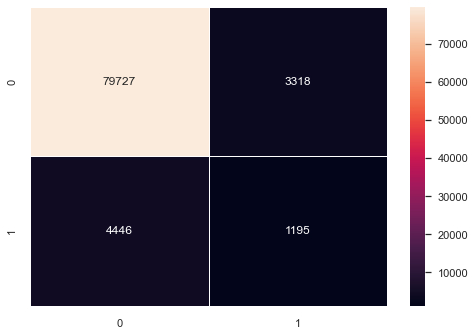

In [78]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

# predict the target variable using the trained model
y_test_pred = clf.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

As we can see adding the new features 9 and 240 already causes a significant improvement over the previously trained model using only 5, 183, 184, 187.

Thus, as a next attempt for the classification task, we add all raw data into the classifier and see how well this improves the output and which features are deemed important. The additional features will both be tested on the Decision Tree as well as on the Random Forest Classifier.

In [79]:
# create a helper column containing the features we want to use for plotting
raw_columns = ['serial_number']

for col in df.columns:
    if 'raw' in col:
        raw_columns.append(col)

In [86]:
# split the data into features and target
X = df[raw_columns]
y = df.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_splitter(X, y, random_state=42)

X_train.drop('serial_number', axis=1, inplace=True)
X_test.drop('serial_number', axis=1, inplace=True)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (207998, 21)
X_test: (88686, 21)
y_train: (207998,)
y_test: (88686,)


Scores:
-------------------------
ROC-AUC : 0.6282
Accuracy : 0.9070
Recall   : 0.3088
Precision: 0.2860
F1 Score: 0.2970
F2 Score : 0.3040


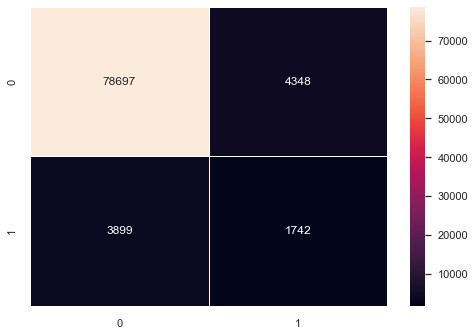

In [87]:
# instantiate and train the model
forest_check = RandomForestClassifier()
forest_check.fit(X_train, y_train)

# create the predictions using the previously trained model
y_test_pred = forest_check.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);

[17:22:57] WARNING: /private/var/folders/4y/dlsvl9zd1blcnj6j3_tsc0j00000gn/T/pip-install-yrved5qh/xgboost_b33a4a38e5e54893acac00c429e943b9/build/temp.macosx-12.1-arm64-3.9/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores:
-------------------------
ROC-AUC : 0.6319
Accuracy : 0.8985
Recall   : 0.3265
Precision: 0.2614
F2 Score : 0.3110


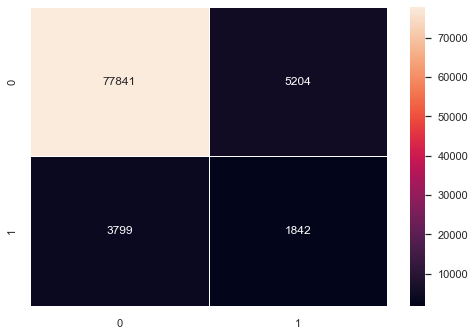

In [85]:
clf = XGBClassifier()
clf.fit(X_train, y_train)

# predict the target variable using the trained model
y_test_pred = clf.predict(X_test)

# calculate the different metrics for the model
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F2 Score : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', linewidths=.5);